# Artem Moskalev. Image Reconstruction and Large Scale Optimization for Inverse Imaging Problems

In [1]:
# import the necessary modules
%matplotlib inline

from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import linopy as ly
from skimage.measure import compare_psnr
from skimage import img_as_float
from scipy.optimize import minimize as sci_min

from tqdm import tqdm_notebook

In [2]:
help(ly)

Help on module linopy:

NAME
    linopy - Module that implements several linear operators.

DESCRIPTION
    Created on Thu Jan 29 13:23:53 2015
    
    @author: stamatis@math.ucla.edu

FUNCTIONS
    Adjshift(x, s, bc='circular')
        Adjoint of the shift operator that can treat different boundary conditions. 
        It applies to an nd-array of arbitrary dimensions. 
        ----------
        Usage: xs=Adjshift(x,[0,1,-3,3],'reflexive')
        ----------
        Parameters
        ----------
        x : nd-array.
        s : vector that matches the dimensions of x, with the corresponding shifts.
        bc: String with the prefered boundary conditions (bc='circular'|'reflexive','zero')
            (Default: 'circular')
    
    im_grad(f, bc='reflexive')
        Computes the gradient of the input image for specified image boundaries. 
        The input image can be multi-dimensional.
    
    im_ndiv(Df, bc='reflexive')
        Computes the adjoint of the image gradient (negativ

In [3]:
# For this homework task we supply you functions which implement the shift operation with mode (circulant, reflexive, zero)
# an example is the the following
x=10*np.random.randint(0,100,(10))
y=10*np.random.randint(0,100,(10))

sh=np.random.randint(-5,5,1)
xs=ly.shift(x,sh,bc='reflexive')
yAs=ly.Adjshift(y,sh,bc='reflexive')
e=np.dot(xs.flatten(),y.flatten())-np.dot(x.flatten(),yAs.flatten()) # check whether the shift and the adjoint of the shift
                                                                     # are correct
print('Error:', e)

Error: 0


In [4]:
print('Original',x)
print('Shifted(reflexive)',xs)

Original [620  20 800 860 400 180 290  60 490 580]
Shifted(reflexive) [620  20 800 860 400 180 290  60 490 580]


In [5]:
def show_images(input, input_title, output, output_title):
    fig, (im_input, im_output) = plt.subplots(1, 2, figsize=(15, 35))
    im_input.imshow(input, cmap='gray')
    im_input.set_title(input_title)
    im_input.set_axis_off()
    im_output.imshow(output, cmap='gray')
    im_output.set_title(output_title)
    im_output.set_axis_off()
    fig.show()

## Image denoising using Total Variation and Tikhonov regularizers

### Exercise 1 (35%)

a) **Total Variation (TV) image denoising** problem defines as

$$
\mathbf{\hat{x}} = \text{arg}\,\text{min} \frac{1}{2} \| \mathbf{y} - \mathbf{x} \|_2^2 + \lambda \sum \limits_{k = 1}^{K} \| (\nabla \mathbf{x} )_k \|, \text{ } \mathbf{x} \in \mathbf{R}^n,
$$

where $ \mathbf{y} $ is a given image and $ \mathbf{x} $ is an original image. 

To find the $ \mathbf{\hat{x}} $ we need to solve the dual problem 

$$
\mathbf{\hat{w}} = \text{arg}\,\text{min} \frac{1}{2} \| \mathbf{y} - \lambda \nabla^{*} \mathbf{w}  \|_2^2, \text{ } \| \mathbf{w} \|_{\infty, 2} \le 1 ,
$$

which is smooth. Your task is to implement the algorithms below, solve the dual problem and then find the solution of the primal problem: 

a) The standard Gradient Descent algotithm (GD),

b) The Accelerated Gradient Descent algorithm proposed by Nesterov in 1983 (AGD).

- use a fixed step size for GD and AGD: $ t_k = \frac{1}{L} $, where $ L $ corresponds to the Lipschitz constant for the dual problem, and its value can be found in https://web.iem.technion.ac.il/images/user-files/becka/papers/27.pdf ;
- i) the gradient operator and its adjoint should be computed using circulant convolution by assuming periodic boundary conditions.
ii) the gradient operator and its adjoint should also be computed by assuming symmetric boundary conditions, to do this use the code we provided for the shifts.

Denoise the given images using the **TV image denoising algorithm** (for both GD and AGD). Since the $ \lambda $ is a free parameter, you need to fine-tune it and provide a plot for the final reconstruction error as a function of the $ \lambda $ parameter for both boundary schemes. Using the best $ \lambda $ parameter provide plots of the evolution of the objective function through the iterations and comment on the convergence using either one of the gradient descent schemes.


In [6]:
#lambda - psnr

/home/art_mos/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


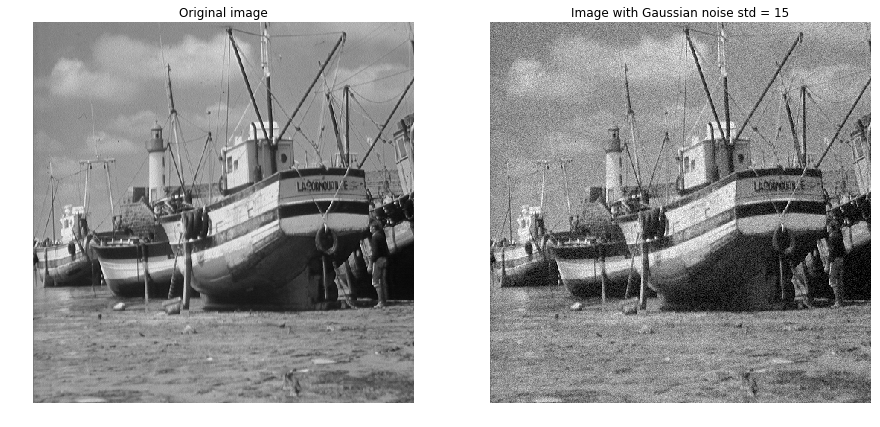

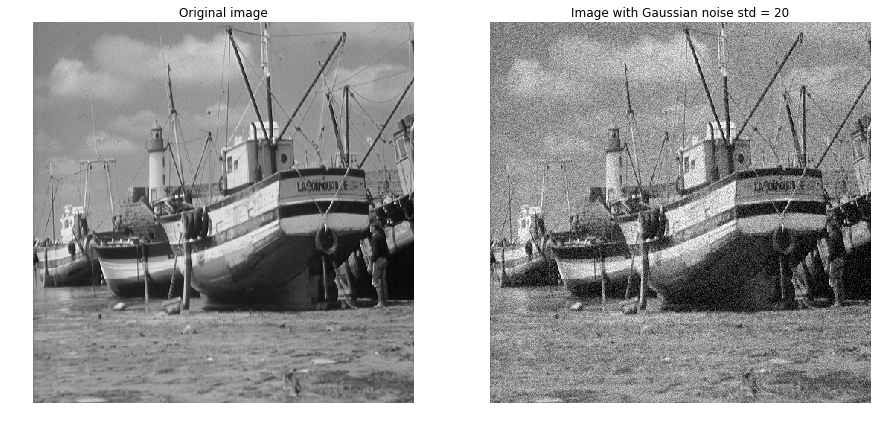

In [7]:
# read images

image_original = img_as_float(io.imread('images/boat_original.png'))
image_gaussian_1 = img_as_float(io.imread('images/boat_noised_15.png'))
image_gaussian_2 = img_as_float(io.imread('images/boat_noised_20.png'))

# show images

show_images(image_original, 'Original image', image_gaussian_1, 'Image with Gaussian noise std = 15')
show_images(image_original, 'Original image', image_gaussian_2, 'Image with Gaussian noise std = 20')

###### A. The standard Gradient Descent algotithm:

In [8]:
def gradec(X, n_iter=20, lambd=1e-2, bc='reflexive'):
    
    def inf2norm(img):
        out = img.copy()
        lpnorm = np.stack((np.sqrt(np.power(out[:,:,0], 2)+np.power(out[:,:,1], 2)), 
                             np.sqrt(np.power(out[:,:,0], 2)+np.power(out[:,:,1], 2))), axis=2)
        out[lpnorm>1] = np.divide(out[lpnorm > 1], lpnorm[lpnorm > 1])
        return out
    
    w, xStep = inf2norm(ly.im_grad(X, bc)), None
    obj_iter = list()

    for _ in range((n_iter)):
        wHat = w
        w = inf2norm(wHat - lambd*ly.im_grad(ly.im_ndiv(wHat, bc)*lambd-X, bc)/(16*lambd**2))
        obj_iter.append(0.5*np.linalg.norm(X-lambd*ly.im_ndiv(w, bc)))
        
    xStep = X-lambd*ly.im_ndiv(w, bc)
        
    obj = 0.5*np.linalg.norm(X-lambd*ly.im_ndiv(w, bc))
    return img_as_float(xStep), compare_psnr(image_original, img_as_float(xStep)), obj, obj_iter

- Fine tune $\lambda$:

In [9]:
Lambdas = np.linspace(1e-5, 1., 20)
pscores1, pscores2, obj_scores1, obj_scores2 = list(), list(), list(), list()
for each_lambda in tqdm_notebook(Lambdas):
    _, pscore1, obj1,_ =gradec(image_gaussian_1, n_iter=20, lambd=each_lambda)
    _, pscore2, obj2,_ =gradec(image_gaussian_2, n_iter=20, lambd=each_lambda)
    pscores1.append(pscore1)
    pscores2.append(pscore2)
    obj_scores1.append(obj1)
    obj_scores2.append(obj2)

A Jupyter Widget

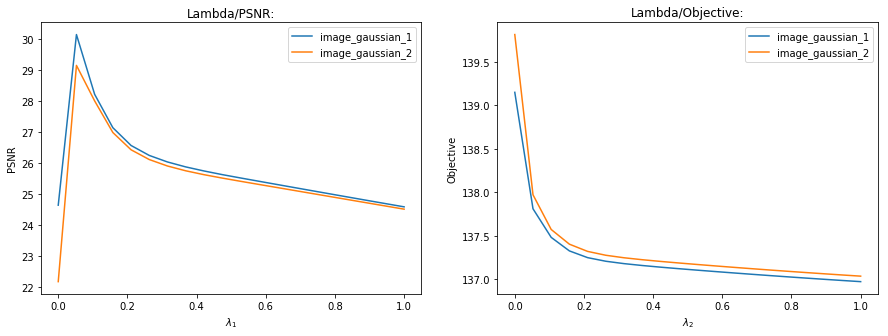

In [10]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(Lambdas, pscores1, label='image_gaussian_1')
ax[0].plot(Lambdas, pscores2, label='image_gaussian_2')
ax[0].set_xlabel('$\lambda_1$')
ax[0].set_ylabel('PSNR')
ax[0].set_title('Lambda/PSNR:')
ax[0].legend()

ax[1].plot(Lambdas, obj_scores1, label='image_gaussian_1')
ax[1].plot(Lambdas, obj_scores2, label='image_gaussian_2')
ax[1].set_xlabel('$\lambda_2$')
ax[1].set_ylabel('Objective')
ax[1].set_title('Lambda/Objective:')
ax[1].legend();

So, we see that our optimal $\lambda_1$ lays somewhere around 0.03, and $\lambda_2$ is around 0.06

In [11]:
TV1,_,_,grad_conv1 =gradec(image_gaussian_1, n_iter=20, lambd=0.03)
TV2,_,_,_ =gradec(image_gaussian_2, n_iter=20, lambd=0.06)

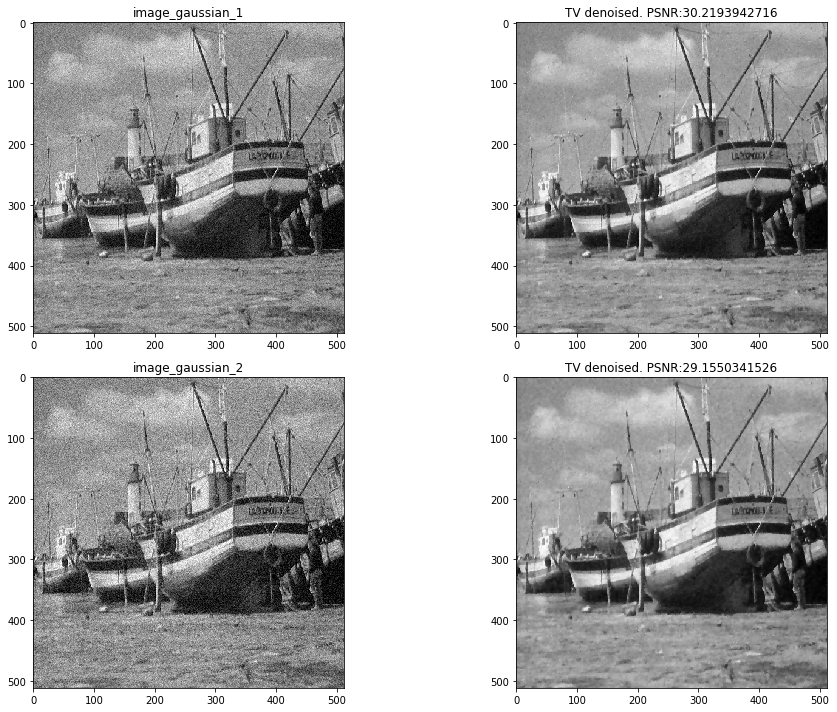

In [12]:
fig, ax = plt.subplots(2,2, figsize = (15,10))
ax[0,0].imshow(image_gaussian_1, cmap='gray')
ax[0,0].set_title('image_gaussian_1')
ax[0,1].imshow(TV1, cmap='gray')
ax[0,1].set_title('TV denoised. PSNR:' + str(compare_psnr(image_original, TV1)))

ax[1,0].imshow(image_gaussian_2, cmap='gray')
ax[1,0].set_title('image_gaussian_2')
ax[1,1].imshow(TV2, cmap='gray')
ax[1,1].set_title('TV denoised. PSNR:' + str(compare_psnr(image_original, TV2)))
plt.tight_layout();

###### B. The Accelerated Gradient Descent algorithm:

In [13]:
def accsgradec(X, init_t=1., n_iter=20, lambd=1e-2, bc='reflexive'):
    
    def inf2norm(img):
        out = img.copy()
        pre_norm = np.stack((np.sqrt(np.power(out[:,:,0], 2)+np.power(out[:,:,1], 2)), 
                             np.sqrt(np.power(out[:,:,0], 2)+np.power(out[:,:,1], 2))), axis=2)
        out[pre_norm>1] = np.divide(out[pre_norm > 1], pre_norm[pre_norm > 1])
        return out
    
    w, xStep, obj_iter = inf2norm(ly.im_grad(X, bc)), None, list()
    w_k = w

    for i in range((n_iter)):
        wHat = inf2norm(w_k - lambd*ly.im_grad(ly.im_ndiv(w_k, bc)*lambd-X,bc)*(1/(16*lambd**2)))
        
        t_k = (1+np.sqrt(1+4*init_t**2))/2
        w_k_new = wHat + (init_t - 1)/(t_k)*(wHat - w)

        w, init_t = wHat, t_k
        w_k = w_k_new
        
        obj_iter.append(0.5*np.linalg.norm(X-lambd*ly.im_ndiv(w, bc)))
        
    xStep = X-lambd*ly.im_ndiv(w, bc)
    obj = 0.5*np.linalg.norm(X-lambd*ly.im_ndiv(w, bc))
        
    return img_as_float(xStep), compare_psnr(image_original, img_as_float(xStep)), obj, obj_iter

- Fine tune $\lambda$:

######  Circular boundary conditions:

In [14]:
Lambdas = np.linspace(0, 0.15, 20)
pscores1, pscores2, obj_scores1, obj_scores2 = list(), list(), list(), list()
for each_lambda in tqdm_notebook(Lambdas):
    _, pscore1, obj1,_ =accsgradec(image_gaussian_1, n_iter=20, lambd=each_lambda, bc = 'circular')
    _, pscore2, obj2,_ =accsgradec(image_gaussian_2, n_iter=20, lambd=each_lambda, bc = 'circular')
    pscores1.append(pscore1)
    pscores2.append(pscore2)
    obj_scores1.append(obj1)
    obj_scores2.append(obj2)

A Jupyter Widget

/home/art_mos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/art_mos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  
/home/art_mos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


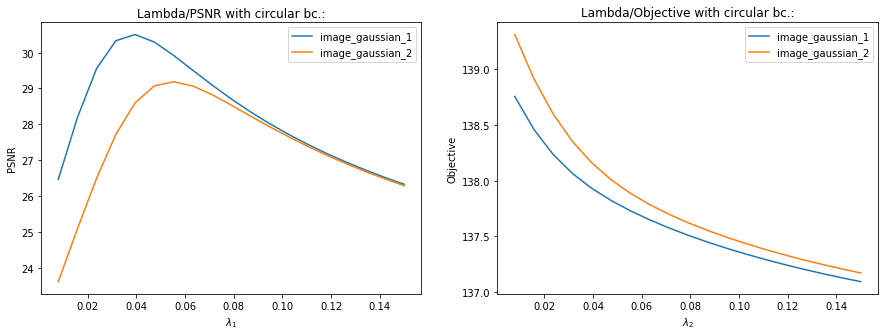

In [15]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(Lambdas, pscores1, label='image_gaussian_1')
ax[0].plot(Lambdas, pscores2, label='image_gaussian_2')
ax[0].set_xlabel('$\lambda_1$')
ax[0].set_ylabel('PSNR')
ax[0].set_title('Lambda/PSNR with circular bc.:')
ax[0].legend()

ax[1].plot(Lambdas, obj_scores1, label='image_gaussian_1')
ax[1].plot(Lambdas, obj_scores2, label='image_gaussian_2')
ax[1].set_xlabel('$\lambda_2$')
ax[1].set_ylabel('Objective')
ax[1].set_title('Lambda/Objective with circular bc.:')
ax[1].legend();

###### Reflexive boundary conditions:

In [16]:
Lambdas = np.linspace(0, .15, 20)
pscores1, pscores2, obj_scores1, obj_scores2 = list(), list(), list(), list()
for each_lambda in tqdm_notebook(Lambdas):
    _, pscore1, obj1, _ =accsgradec(image_gaussian_1, n_iter=20, lambd=each_lambda, bc = 'reflexive')
    _, pscore2, obj2, _ =accsgradec(image_gaussian_2, n_iter=20, lambd=each_lambda, bc = 'reflexive')
    pscores1.append(pscore1)
    pscores2.append(pscore2)
    obj_scores1.append(obj1)
    obj_scores2.append(obj2)

A Jupyter Widget

/home/art_mos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/art_mos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  
/home/art_mos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


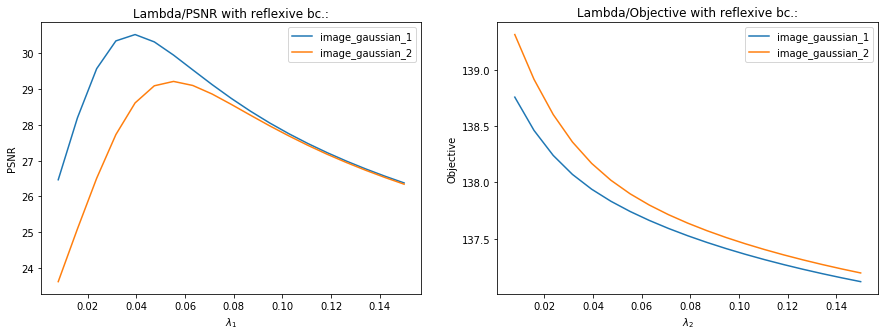

In [17]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(Lambdas, pscores1, label='image_gaussian_1')
ax[0].plot(Lambdas, pscores2, label='image_gaussian_2')
ax[0].set_xlabel('$\lambda_1$')
ax[0].set_ylabel('PSNR')
ax[0].set_title('Lambda/PSNR with reflexive bc.:')
ax[0].legend()

ax[1].plot(Lambdas, obj_scores1, label='image_gaussian_1')
ax[1].plot(Lambdas, obj_scores2, label='image_gaussian_2')
ax[1].set_xlabel('$\lambda_2$')
ax[1].set_ylabel('Objective')
ax[1].set_title('Lambda/Objective with reflexive bc.:')
ax[1].legend();

Thus, optimal lambdas for both regimes lay around 0.04. Let's denoise an image with these optimal parameters.

In [18]:
ATV1_refl,_,_,acgrad_conv1 =accsgradec(image_gaussian_1, n_iter=20, lambd=.04, bc = 'reflexive')
ATV2_refl,_,_,_ =accsgradec(image_gaussian_2, n_iter=20, lambd=.04, bc = 'reflexive')
ATV1_circ,_,_,_ =accsgradec(image_gaussian_1, n_iter=20, lambd=.04, bc = 'circular')
ATV2_circ,_,_,_ =accsgradec(image_gaussian_2, n_iter=20, lambd=.04, bc = 'circular')

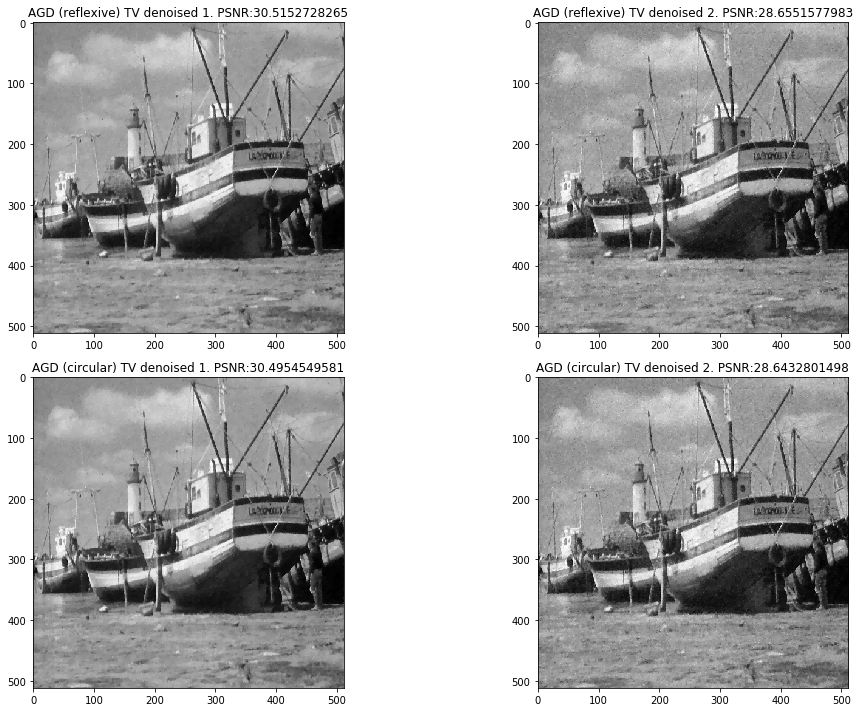

In [19]:
fig, ax = plt.subplots(2,2, figsize = (15,10))
ax[0,0].imshow(ATV1_refl, cmap='gray')
ax[0,0].set_title('AGD (reflexive) TV denoised 1. PSNR:' + str(compare_psnr(image_original, ATV1_refl)))

ax[0,1].imshow(ATV2_refl, cmap='gray')
ax[0,1].set_title('AGD (reflexive) TV denoised 2. PSNR:' + str(compare_psnr(image_original, ATV2_refl)))

ax[1,0].imshow(ATV1_circ, cmap='gray')
ax[1,0].set_title('AGD (circular) TV denoised 1. PSNR:' + str(compare_psnr(image_original, ATV1_circ)))

ax[1,1].imshow(ATV2_circ, cmap='gray')
ax[1,1].set_title('AGD (circular) TV denoised 2. PSNR:' + str(compare_psnr(image_original, ATV2_circ)))
plt.tight_layout();

##### Convergence:

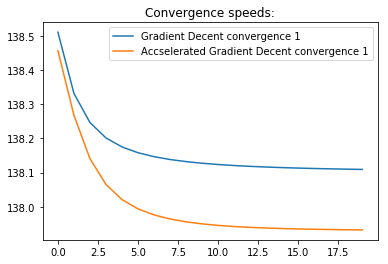

In [20]:
plt.plot(grad_conv1, label='Gradient Decent convergence 1')
plt.plot(acgrad_conv1, label='Accselerated Gradient Decent convergence 1')
plt.title('Convergence speeds:')
plt.legend();

We see that accelerated GD converges faster.

### Exercise 2 (15%)

The **Tikhonov regularization with the gradient operator for image denoising** problem defines as

$$
\mathbf{\hat{x}} = \text{arg}\,\text{min} \frac{1}{2} \| \mathbf{y} - \mathbf{Ix} \|_2^2 + \lambda \| \nabla \mathbf{x}  \|_2^2, \text{ } \mathbf{x} \in \mathbf{R}^n, 
$$

where is $ I $ is the identity matrix.

This is a quadratic problem, so you can use built-in Conjugate Gradient method (CG) to solve it. Since $ I $ is a circulant matrix, you can also solve the problem in the DFT domain. 

Denoise the given images using the **Tikhonov regularization with the gradient operator**, fine-tune $ \lambda $ and provide all the plots as in **Ex.1**.

Link to the CG tutorial (if you do not know what is it): https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf

*Note*:
- the gradient operator and its adjoint should be computed using circulant convolution by assuming periodic boundary conditions.
- the gradient operator, its adjoint and the blur kernel should also be computed by assuming *symmetric* boundary conditions. For this steps use the provided code.


*Compare the reconstructions between the TV and the Tikhonov regularizators and the different boundary assumptions.*

/home/art_mos/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


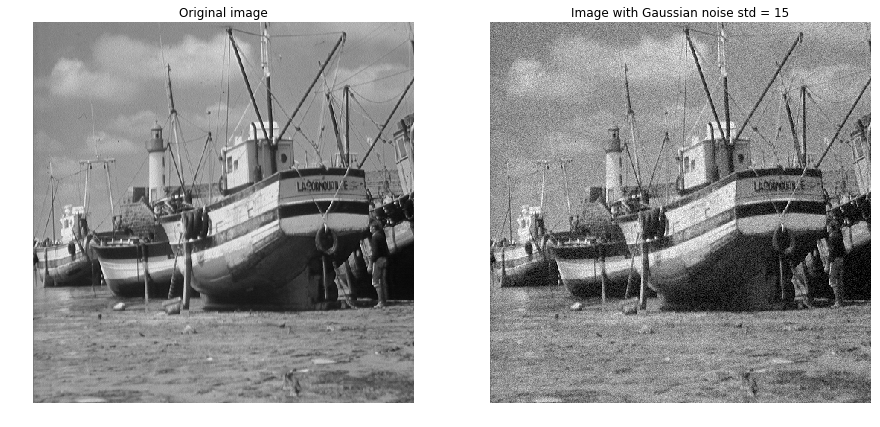

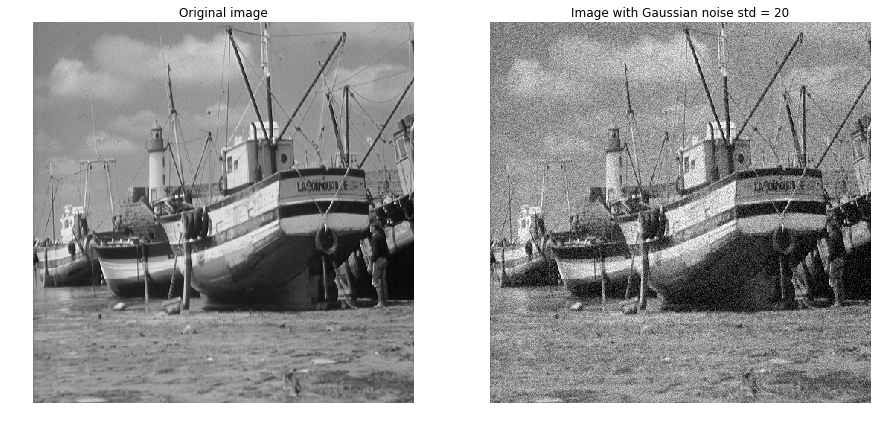

In [21]:
# read images

image_original = img_as_float(io.imread('images/boat_original.png'))
image_gaussian_1 = img_as_float(io.imread('images/boat_noised_15.png'))
image_gaussian_2 = img_as_float(io.imread('images/boat_noised_20.png'))

# show images

show_images(image_original, 'Original image', image_gaussian_1, 'Image with Gaussian noise std = 15')
show_images(image_original, 'Original image', image_gaussian_2, 'Image with Gaussian noise std = 20')

Since you allowed to use built-in functions, I suggest to use scipy minimize function, it has Conjugate Gradient implemented. All we need to do is to specify the loss, the gradient itself (not necessary for scipy, it can evaluate it numerically, but with provided gradient, it converges much faster):

In [22]:
LossFunc = lambda x, y, lamb, bc: 0.5*np.power(np.linalg.norm(y - x.reshape(y.shape)),2) + \
              np.power(np.linalg.norm(ly.im_grad(x.reshape(y.shape),bc=bc)),2)*lamb
    
Gradi = lambda x, y, lamb, bc: x.ravel() - y.ravel() + \
                   2*ly.im_ndiv(ly.im_grad(x.reshape(y.shape),bc), bc).ravel()*lamb
    
ConjGrad = lambda fun, x0, args, method, jac: img_as_float(sci_min(**locals()).x.ravel())

 - ##### Reflexive boundary conditions:

In [23]:
CG1 = ConjGrad(fun=LossFunc, x0=image_gaussian_1.ravel(), args=(image_gaussian_1, 1, 'reflexive'),
              method='CG',jac=Gradi).reshape(image_gaussian_1.shape)

CG2 = ConjGrad(fun=LossFunc, x0=image_gaussian_2.ravel(), args=(image_gaussian_2, 1, 'reflexive'),
              method='CG',jac=Gradi).reshape(image_gaussian_2.shape)

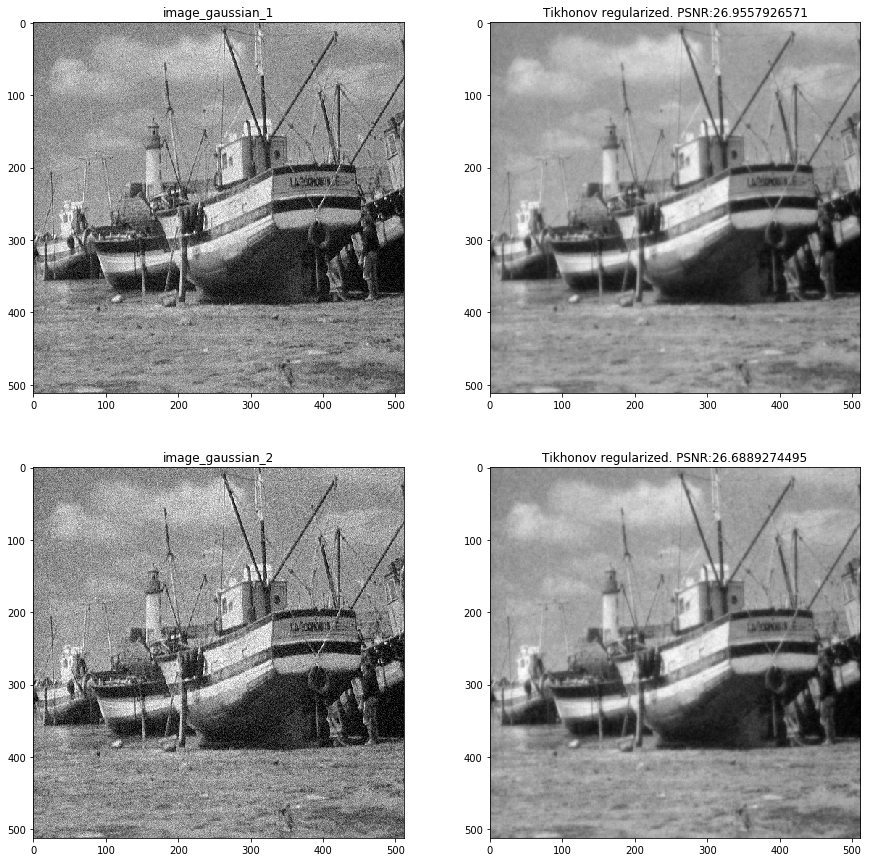

In [24]:
fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0,0].imshow(image_gaussian_1, cmap='gray')
ax[0,0].set_title('image_gaussian_1')
ax[0,1].imshow(CG1, cmap='gray')
ax[0,1].set_title('Tikhonov regularized. PSNR:'+str(compare_psnr(image_original, CG1)))

ax[1,0].imshow(image_gaussian_2, cmap='gray')
ax[1,0].set_title('image_gaussian_2')
ax[1,1].imshow(CG2, cmap='gray')
ax[1,1].set_title('Tikhonov regularized. PSNR:'+str(compare_psnr(image_original, CG2)));

 - Fine tune lambda:

In [25]:
Lambdas = np.linspace(0,1,15)
psnrs1, psnrs2 = list(), list()
for each_lambda in tqdm_notebook(Lambdas):
    tikh_denoised1 = ConjGrad(fun=LossFunc, x0=image_gaussian_1.ravel(), args=(image_gaussian_1, each_lambda, 'reflexive'),
              method='CG',jac=Gradi).reshape(image_gaussian_1.shape)
    
    tikh_denoised2 = ConjGrad(fun=LossFunc, x0=image_gaussian_2.ravel(), args=(image_gaussian_2, each_lambda, 'reflexive'),
              method='CG',jac=Gradi).reshape(image_gaussian_2.shape)
    
    psnrs1.append(compare_psnr(image_original, tikh_denoised1))
    psnrs2.append(compare_psnr(image_original, tikh_denoised2))

A Jupyter Widget

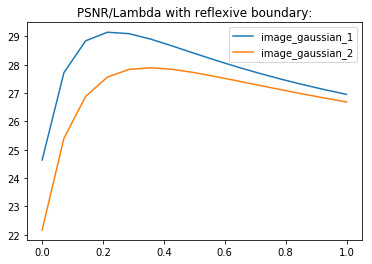

In [26]:
plt.plot(Lambdas, psnrs1, label='image_gaussian_1')
plt.plot(Lambdas, psnrs2, label='image_gaussian_2')
plt.legend()
plt.title('PSNR/Lambda with reflexive boundary:');

Thus, our optimal $\lambda$ is around 0.27.

In [27]:
CG1_refl = ConjGrad(fun=LossFunc, x0=image_gaussian_1.ravel(), args=(image_gaussian_1, 0.27, 'reflexive'),
              method='CG',jac=Gradi).reshape(image_gaussian_1.shape)

CG2_refl = ConjGrad(fun=LossFunc, x0=image_gaussian_2.ravel(), args=(image_gaussian_2, 0.27, 'reflexive'),
              method='CG',jac=Gradi).reshape(image_gaussian_2.shape)

/home/art_mos/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


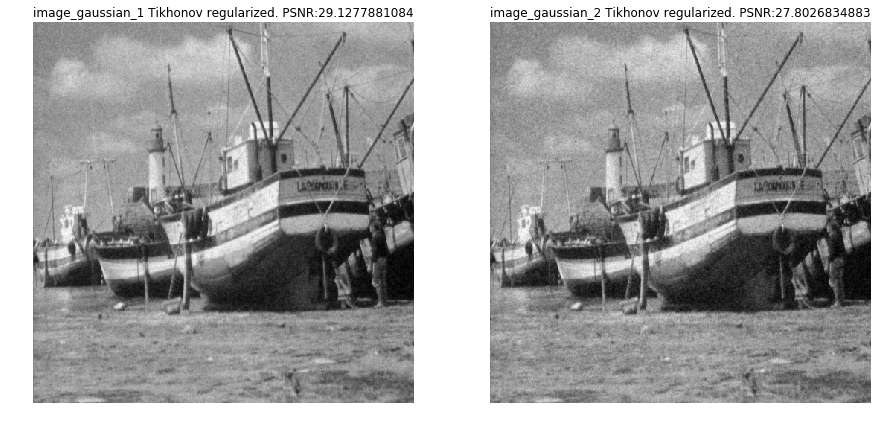

In [28]:
show_images(CG1_refl,'image_gaussian_1 Tikhonov regularized. PSNR:' + str(compare_psnr(image_original, CG1_refl))
            ,CG2_refl,'image_gaussian_2 Tikhonov regularized. PSNR:'+ str(compare_psnr(image_original, CG2_refl)))

 - ##### Circular boundary conditions:

 - Fine tune lambda:

In [29]:
Lambdas = np.linspace(0,1,15)
psnrs1, psnrs2 = list(), list()
for each_lambda in tqdm_notebook(Lambdas):
    tikh_denoised1 = ConjGrad(fun=LossFunc, x0=image_gaussian_1.ravel(), args=(image_gaussian_1, each_lambda, 'circular'),
              method='CG',jac=Gradi).reshape(image_gaussian_1.shape)
    
    tikh_denoised2 = ConjGrad(fun=LossFunc, x0=image_gaussian_2.ravel(), args=(image_gaussian_2, each_lambda, 'circular'),
              method='CG',jac=Gradi).reshape(image_gaussian_2.shape)
    
    psnrs1.append(compare_psnr(image_original, tikh_denoised1))
    psnrs2.append(compare_psnr(image_original, tikh_denoised2))

A Jupyter Widget

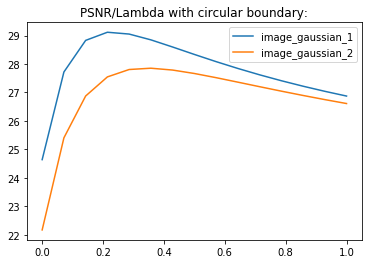

In [30]:
plt.plot(Lambdas, psnrs1, label='image_gaussian_1')
plt.plot(Lambdas, psnrs2, label='image_gaussian_2')
plt.legend()
plt.title('PSNR/Lambda with circular boundary:');

Here, an optimal lambda is around 0.23

In [31]:
CG1_circ = ConjGrad(fun=LossFunc, x0=image_gaussian_1.ravel(), args=(image_gaussian_1, 0.23, 'circular'),
              method='CG',jac=Gradi).reshape(image_gaussian_1.shape)

CG2_circ = ConjGrad(fun=LossFunc, x0=image_gaussian_2.ravel(), args=(image_gaussian_2, 0.23, 'circular'),
              method='CG',jac=Gradi).reshape(image_gaussian_2.shape)

/home/art_mos/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


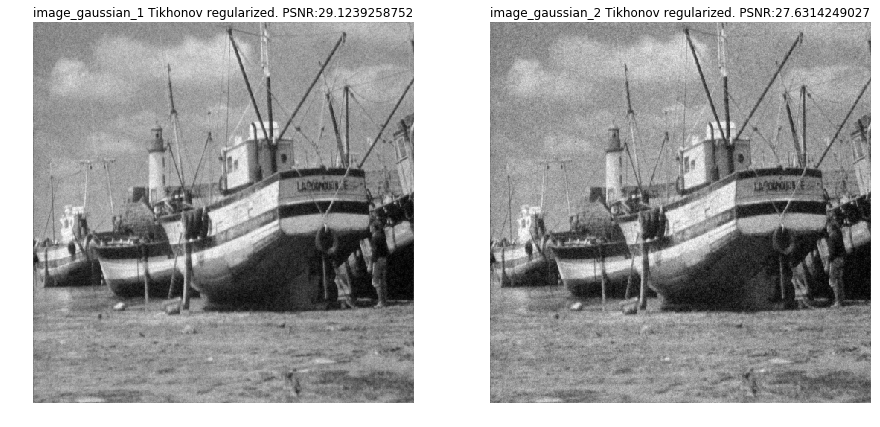

In [32]:
show_images(CG1_circ,'image_gaussian_1 Tikhonov regularized. PSNR:' + str(compare_psnr(image_original, CG1_circ))
            ,CG2_circ,'image_gaussian_2 Tikhonov regularized. PSNR:'+ str(compare_psnr(image_original, CG2_circ)))

 - ##### Convergence and comparison with TV method.

We observed that for total variation 10-11 iterations are enough to converge, let's check how many CG will take.

In [33]:
sci_min(fun=LossFunc, x0=image_gaussian_1.ravel(), args=(image_gaussian_1, 0.27, 'reflexive'),
        method='CG', jac=Gradi, options={'dist':True})

/home/art_mos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: OptimizeWarning: Unknown solver options: dist
  


     fun: 507.7368881208066
     jac: array([ -4.05753669e-07,  -3.87812182e-07,  -9.58187222e-08, ...,
        -1.24434097e-06,  -1.56173704e-06,  -3.19668173e-07])
 message: 'Optimization terminated successfully.'
    nfev: 26
     nit: 12
    njev: 26
  status: 0
 success: True
       x: array([ 0.48948221,  0.49247687,  0.49680664, ...,  0.41826772,
        0.40359867,  0.35411334])

So, it takes more iterations to converge, in addition PSNR is lower. Byt anyway, I would prefer TV denoising, because it tends to preserve geometrical structure of an image and I like a cartoon effect it produces.